In [1]:
import pyspark
from random import randint, random, choice
import matplotlib.pyplot as plt

sc = pyspark.SparkContext('local[*]')

In [6]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *
from datetime import datetime

dataset = datasetGenerator()
dataset.addGenerator(intGenerator(),min=1,max=100,keyName="bookId")
dataset.addGenerator(intGenerator(),min=1,max=10000,keyName="tokenId")

rdd = sc.parallelize(dataset.generateDataset(1000000)).persist()

In [9]:
tf = rdd.map(lambda x: ((x.get('tokenId'), x.get('bookId')), 1)).reduceByKey(lambda a,b: a+b)
tf.top(5, lambda x: x[1])

[((3462, 75), 8),
 ((2369, 76), 8),
 ((966, 95), 8),
 ((217, 63), 8),
 ((788, 65), 8)]

In [10]:
toplot = tf.map(lambda x: (x[1], 1)).reduceByKey(lambda a,b: a+b)
toplot.collect()

[(1, 368068),
 (2, 183269),
 (3, 61391),
 (4, 15344),
 (5, 3196),
 (6, 543),
 (7, 81),
 (8, 5)]

<BarContainer object of 8 artists>

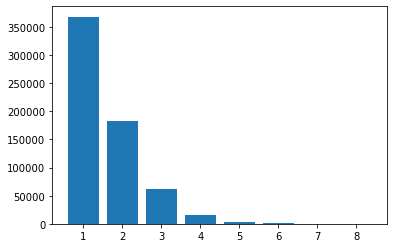

In [11]:
plt.bar(toplot.map(lambda x: x[0]).collect(),toplot.map(lambda x: x[1]).collect() )

In [16]:
df = tf.map(lambda x: (x[0][0], 1)).reduceByKey(lambda a,b: a+b)
df.top(5, lambda x: x[1])

[(7615, 80), (3360, 79), (9415, 79), (2337, 79), (3814, 79)]

In [18]:
# np.log(totBooks/df)
totBooks = tf.map(lambda x: x[0][1]).distinct().count()
totBooks

100

In [21]:
idf = df.map(lambda x: (x[0], (x[1], np.log(totBooks/x[1]))))
idf.take(5)

[(4716, (64, 0.44628710262841953)),
 (4008, (57, 0.5621189181535412)),
 (4200, (62, 0.47803580094299974)),
 (2064, (64, 0.44628710262841953)),
 (6024, (63, 0.4620354595965586))]

In [22]:
tf.take(5)

[((6325, 17), 1),
 ((9354, 4), 2),
 ((7093, 9), 2),
 ((9323, 63), 2),
 ((5386, 44), 3)]

In [28]:
tfidf = tf.map(lambda x: (x[0][0], x)).join(idf).map(lambda x: (x[1][0][0], x[1][0][1], x[1][1][0], x[1][1][1], x[1][0][1]*x[1][1][1]))
tfidf.top(5, lambda x: 1/x[4])

[((7615, 91), 1, 80, 0.22314355131420976, 0.22314355131420976),
 ((7615, 35), 1, 80, 0.22314355131420976, 0.22314355131420976),
 ((7615, 87), 1, 80, 0.22314355131420976, 0.22314355131420976),
 ((7615, 92), 1, 80, 0.22314355131420976, 0.22314355131420976),
 ((7615, 24), 1, 80, 0.22314355131420976, 0.22314355131420976)]